In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import pyslha
import ROOT

ROOT.gSystem.Load(os.path.abspath(os.path.join(os.getcwd(),"../Delphes/libDelphes.so")))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.24/06


# Load Model Parameters

In [2]:
parameters = pyslha.readSLHAFile('../DMSimp_monojet_LO/Cards/param_card.dat')
mMed = parameters.blocks['MASS'][55]
mDM = parameters.blocks['MASS'][52]
gVq = parameters.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
gAq = parameters.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
gVx = parameters.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
gAx = parameters.blocks['DMINPUTS'][3] # Mediator-DM axial coupling

# Set Delphes output file

In [3]:
# inputFiles = {'point1' : '../DMSimp_monojet_LO/Events/run_02/tag_1_delphes_events.root'}
inputFiles = {'point1' : '../DMSimp_monojet_LO/Events/run_04/tag_1_delphes_events.root'}

# Define Cuts

In [4]:
# Cuts 
## jets
pTj1min = 100.
pTjmin = 25.
etamax = 2.4
## MET
minMET = 250.
## Electrons
pTmin_el = 10.
etamax_el = 2.5
nMax_el = 0
## Muons
pTmin_mu = 10.
etamax_mu = 2.4
nMax_mu = 0


# Load events, apply cuts and store relevant info

In [5]:
pTj1 = []
weights = []
met = []
dmPT = []
njets = []
totalweight = 0.0
cutFlow = OrderedDict({'Electron Veto' : 0, 'Muon Veto' : 0, 'pTmiss cut': 0, 
                       'pT(j1) cut' : 0, 'deltaPhi cut' : 0})
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        

        particles = tree.Particle
       
        # Get DM particles (gen level)
        dmList = []
        for ip in range(particles.GetEntries()):
            p = particles.At(ip)
            if abs(p.PID) != 52:
                continue
            if p.Status != 1:
                continue
            dmList.append(p)
            
        if len(dmList) !=2:
            # Skip events with Mediator -> j j
            continue

        jets = tree.Jet
        weight = tree.Event.At(0).Weight
        weight = weight/nevts
        totalweight += weight

#         missingET = tree.MissingET.At(0)
        missingET = tree.GenMissingET.At(0)  # USE REAL MISSING ET!
        electrons = tree.Electron
        muons = tree.Electron
    
        # Filter electrons:
        electronList = []
        for iel in range(electrons.GetEntries()):
            electron = electrons.At(iel)
            if electron.PT < pTmin_el:
                continue
            if abs(electron.Eta) > etamax_el:
                continue
            electronList.append(electron)
        
        # Filter muons:
        muonList = []
        for imu in range(muons.GetEntries()):
            muon = muons.At(imu)
            if muon.PT < pTmin_mu:
                continue
            if abs(muon.Eta) > etamax_mu:
                continue
            muonList.append(muon)
            
        # Filter jets
        jetList = []
        for ijet in range(jets.GetEntries()):
            jet = jets.At(ijet)
            if jet.PT < pTjmin:
                continue
            if abs(jet.Eta) > etamax:
                continue
            jetList.append(jet)  
        jetList = sorted(jetList, key = lambda j: j.PT, reverse=True)    
        
        njets.append(jets.GetEntries())
        
        if len(jetList) > 0:
            deltaPhi = np.abs(jetList[0].Phi-missingET.Phi) 
        else:
            deltaPhi = 0.0

#         Apply cuts:
        ## Veto electrons
        if len(electronList) > nMax_el: continue  
        cutFlow['Electron Veto'] += weight
        ## Veto muons
        if len(muonList) > nMax_mu: continue  
        cutFlow['Muon Veto'] += weight
        ## Cut on MET
        if missingET.MET < minMET: continue              
        cutFlow['pTmiss cut'] += weight
        ## Veto zero jet events
        if len(jetList) < 1 or jetList[0].PT < pTj1min: continue
        cutFlow['pT(j1) cut'] += weight
        if deltaPhi < 0.5: continue
        cutFlow['deltaPhi cut'] += weight            
        
        
        dmPT.append(np.sqrt((dmList[0].Px + dmList[1].Px)**2 + (dmList[0].Py + dmList[1].Py)**2))
        
        # Store relevant data        
        pTj1.append(jetList[0].PT)
        weights.append(weight)
        met.append(missingET.MET)
f.Close()

weights = np.array(weights)
pTj1 = np.array(pTj1)
met = np.array(met)
# genmet = np.array(genmet)
njets = np.array(njets)

In file included from ClassesDict dictionary payload:32:
/home/lessa/MonoXSMS/Delphes/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Error in <TInterpreter::AutoParse>: Error parsing payload code for class GenParticle with content:

#line 1 "ClassesDict dictionary payload"


#define _BACKWARD_BACKWARD_WARNING_H
// Inline headers
/*
 *  Delphes: a framework for fast simulation of a generic collider experiment
 *  Copyright (C) 2012-2014  Universite catholique de Louvain (UCL), Belgium
 *
 *  This program is free software: you can redistribute it and/or modify
 *  it under the terms of the GNU General Public License as published by
 *  the Free Software Foundation, either version 3 of the License, or
 *  (at your option) any later version.
 *
 *  This program is distributed in the hope that it will be useful,
 *  but WITHOUT ANY WARRANTY; without even the implied warran

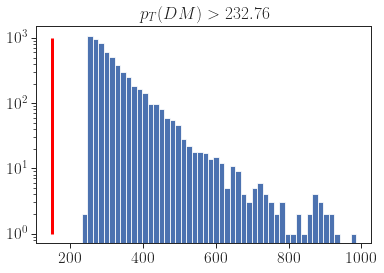

In [6]:
plt.hist(dmPT,bins=50)
plt.title(r'$p_T(DM) > %1.2f$' %min(dmPT))
plt.vlines(x=150.,ymin=1,ymax=1e3,color='red',linewidth=3)
plt.yscale('log')
plt.show()

## Print cutflow

In [7]:
# Print cutflow:
print('totalweight = %1.3f' %totalweight)
for cut,weight in cutFlow.items():
    print(cut,'eff = %1.3f' %(weight/totalweight))

totalweight = 106.642
Electron Veto eff = 1.000
Muon Veto eff = 1.000
pTmiss cut eff = 0.181
pT(j1) cut eff = 0.180
deltaPhi cut eff = 0.118


# Get official CMS data

In [8]:
pickleFile = '../monoJet/CMS-EXO-20-004-data/Signaltemplates_DMsimp_spin-1_Monojet_DF.pcl'
df = pd.read_pickle(pickleFile)

### Filter model

In [9]:
if gAx:
    dfModel = df[(df["$m_{med}$"] == mMed) & (df["$m_{DM}$"] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df["Coupling"] == "Axial")]
elif gVx:
    dfModel = df[(df["$m_{med}$"] == mMed) & (df["$m_{DM}$"] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df["Coupling"] == "Vector")]

if len(dfModel) != 1:
    print('%i data rows selected' %(len(dfModel)))

In [10]:
bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if "bin_" in c}
cmsData = {c : dfModel[c].iloc[0] for c in bins}
rightBin = 2000.
binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()

## Plot Results

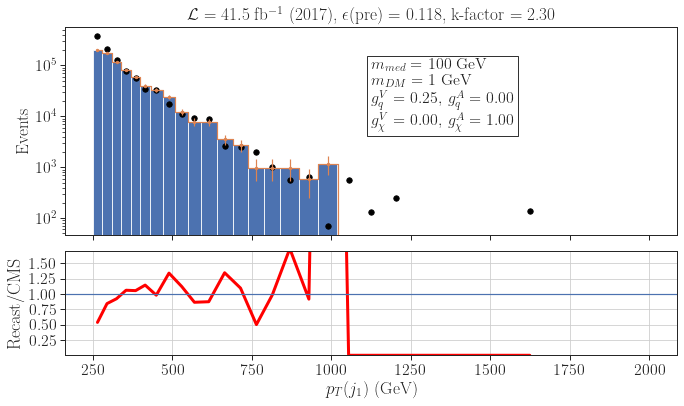

In [30]:
lum2017 = 41.5 #fb^-1
kfactor = 2.3 # NLO (approx) k-factor
weightY = weights*1e3*lum2017*kfactor # weights for the Yield


f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,6))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

# Plot MC bins
binc,binEdges,_= axarr[0].hist(pTj1,bins=list(bins.values())+[rightBin],weights=weightY)
# Plot error bars = sqrt(N)*weight = sqrt((N*weight)*weight)
axarr[0].errorbar(binCenter,binc,yerr = (binc*weightY[0])**0.5, marker = '.', drawstyle = 'steps-mid')

# Plot CMS data
cmsValues = np.array(list(cmsData.values()))
axarr[0].scatter(x=binCenter,y=cmsValues,s=30,c='black')
axarr[0].set_yscale('log')
axarr[0].set_ylabel('Events')

relDiff = np.abs(binc-cmsValues)/cmsValues
ratio = binc/cmsValues
#Plot ratio
axarr[1].plot(binCenter,ratio,color='red',linewidth=3.0)
axarr[1].axhline(y=1.)
axarr[1].set_ylim(0.0,1.7)
axarr[1].set_yticks([0.25,0.5,0.75,1.0,1.25,1.5])
# axarr[1].set_yscale('log')
# axarr[1].set_ylabel('Relative Diff.', fontsize=18) #Y-label
axarr[1].set_ylabel('Recast/CMS', fontsize=18) #Y-label
axarr[1].grid(True)

axarr[1].set_xlabel(r'$p_{T}(j_{1})$ (GeV)')

axarr[0].set_title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f, k-factor = %1.2f' 
          %(lum2017,list(cutFlow.values())[-1]/totalweight,kfactor))
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.5,2.2,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.show()